# Unsupervised Classification

The purpose of this notebook is to provide a baseline of non-supervised
classifiers using textual and visual CLIP encoders in order to assess the
robustness of default representations.

In [34]:
import numpy
import pandas
import pathlib
import shutil

from tqdm import tqdm
from PIL import Image
from transformers import CLIPTokenizer, CLIPTextModel
from transformers import CLIPProcessor, CLIPVisionModel

from typing import Dict, List, Optional, Union

## A) Textual information

In [48]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32",
                                          do_lower_case=True)
# model_base = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model_base = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")


def compute_clip(text: Optional[str] = None,
                 image: Optional[str] = None) -> numpy.ndarray:
    """ Compute pretrained CLIP embeddings for either a sentence or an image.

    TODO: Implement image loading and preprocessing.

    Args:
        text: Sentence to encode
        image: Image.

    Returns:
        a 512-dimensional embedding.
    """
    if text is not None:
        inputs = tokenizer(text, return_tensors="pt", truncation=True,
                           max_length=77)
    if image is not None:
        inputs = processor(images=Image.open(image), return_tensors="pt")

    output = model_base(**inputs).pooler_output.squeeze()
    return output.detach().cpu().numpy()


def compute_embeddings(modal: str,
                       data: Union[pandas.Series, List],
                       delete_after: bool = True,
                       tmp: str = "tmp") -> numpy.ndarray:
    """ Compute embeddings from pretrained models.

    Args:
        modal: Modality to compute.
        data: Source of data to compute embeddings for.
        delete_after: Remove tmp directory with computed embeddings.
        tmp: Name of the directory within which embeddings are saved.
    """
    tmp_dir = pathlib.Path.cwd() / tmp
    if not tmp_dir.exists():
        pathlib.Path.mkdir(tmp_dir, exist_ok=True)
        for i, sample in tqdm(enumerate(data), total=len(data)):
            x = compute_clip(**{modal: sample})
            numpy.save(tmp_dir / str(i), x)
    embeddings = [numpy.load(tmp_dir / (str(i) + '.npy')) \
                  for i in range(len(data))]
    if delete_after:
        shutil.rmtree(tmp_dir)
    return embeddings


Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.7.layer_norm2.weight', 'text_projection.weight', 'text_model.encoder.layers.3.mlp.fc1.weight', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.7.mlp.fc2.bias', 'text_model.encoder.layers.5.layer_norm1.weight', 'text_model.encoder.layers.4.self_attn.k_proj.bias', 'text_model.encoder.layers.6.self_attn.q_proj.weight', 'text_model.encoder.layers.1.self_attn.v_proj.weight', 'text_model.encoder.layers.8.self_attn.q_proj.bias', 'text_model.encoder.layers.9.layer_norm1.bias', 'text_model.encoder.layers.3.self_attn.v_proj.weight', 'text_model.encoder.layers.10.mlp.fc1.bias', 'text_model.encoder.layers.1.mlp.fc2.weight', 'text_model.encoder.layers.2.self_attn.k_proj.bias', 'text_model.encoder.layers.9.mlp.fc2.weight', 'text_model.embeddings.position_ids', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_

In [3]:
artemis_path = pathlib.Path("/mnt/HDD/DATA/ARTEMIS/artemis_official_data"
                            "/official_data/artemis_dataset_release_v0.csv")
artemis = pandas.read_csv(artemis_path) if artemis_path.exists() else IOError
artemis

,art_style,painting,emotion,utterance,repetition
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"When looking at this woman, I am filled with c...",10
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10
...,...,...,...,...,...
454679,Cubism,gino-severini_a-dancer-1,awe,the collection and collage of different colors...,48
454680,Romanticism,ivan-aivazovsky_sea-at-night-1861,awe,The peaceful reflections of the moonlight on t...,8
454681,Romanticism,ivan-aivazovsky_sea-at-night-1861,excitement,I can imagine the sailors resting this peacefu...,8
454682,Romanticism,ivan-aivazovsky_sea-at-night-1861,contentment,The steep mountains and the moonlight provide ...,8


In [4]:
text_x = compute_embeddings(modal='text',
                       data=artemis['utterance'],
                       delete_after=False,
                       tmp="artemis-text-CLIP")

In [5]:
text_x = numpy.array(text_x)
text_x.shape

(454684, 512)

In [31]:
from tools.dim_reduction import Umap, Pca

text_x_2d = Umap(dims=2, nneighs=25)(text_x)
# text_x_2d = Pca(dims=2)(text_x)
text_x_2d.shape

(454684, 2)

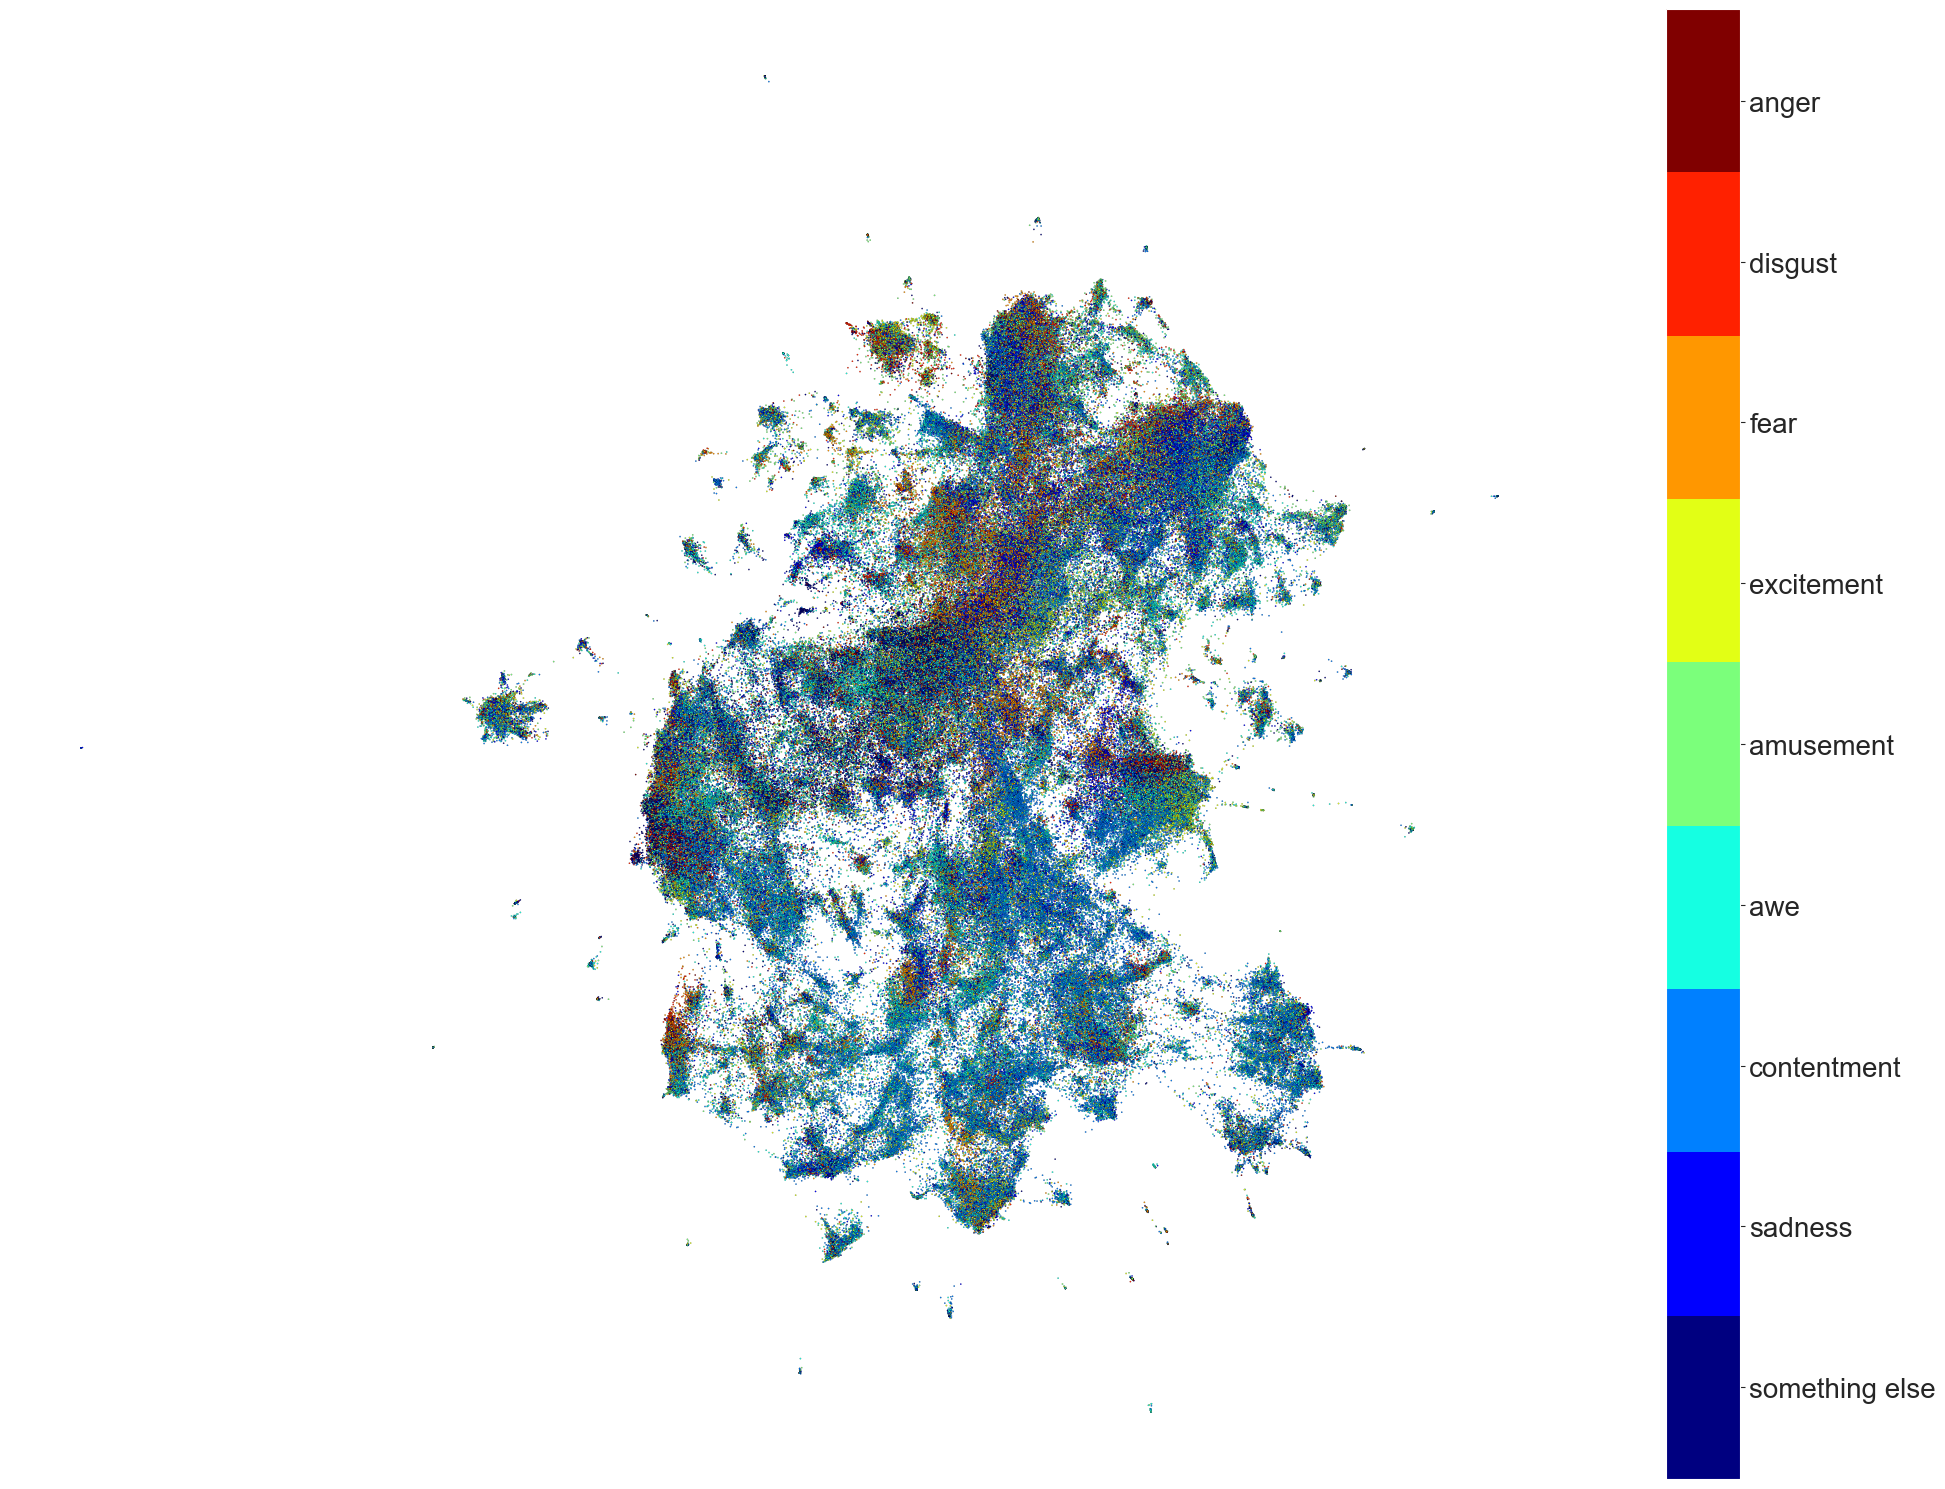

In [25]:
# Actual labels plot
unique_labels = list(artemis['emotion'].unique())
true_labels = numpy.array([unique_labels.index(i) for i in artemis['emotion']])
# good_ones = ['excitement', 'amusement', 'awe', 'contentment']
# bad_ones = ['anger', 'disgust', 'fear', 'sadness']
# true_labels = []
# for tag in artemis['emotion']:
#     if tag in good_ones:
#         true_labels.append(0)
#     elif tag in bad_ones:
#         true_labels.append(1)
#     else:
#         true_labels.append(2)
# unique_labels = ['Positive', 'Negative', 'Something Else']

from visualization.plots_2d import cluster_scatter
cluster_scatter(X=text_x_2d,
                labels=true_labels,
                label_names=unique_labels,
                include_noise=False,
                point_size=1)

### Style

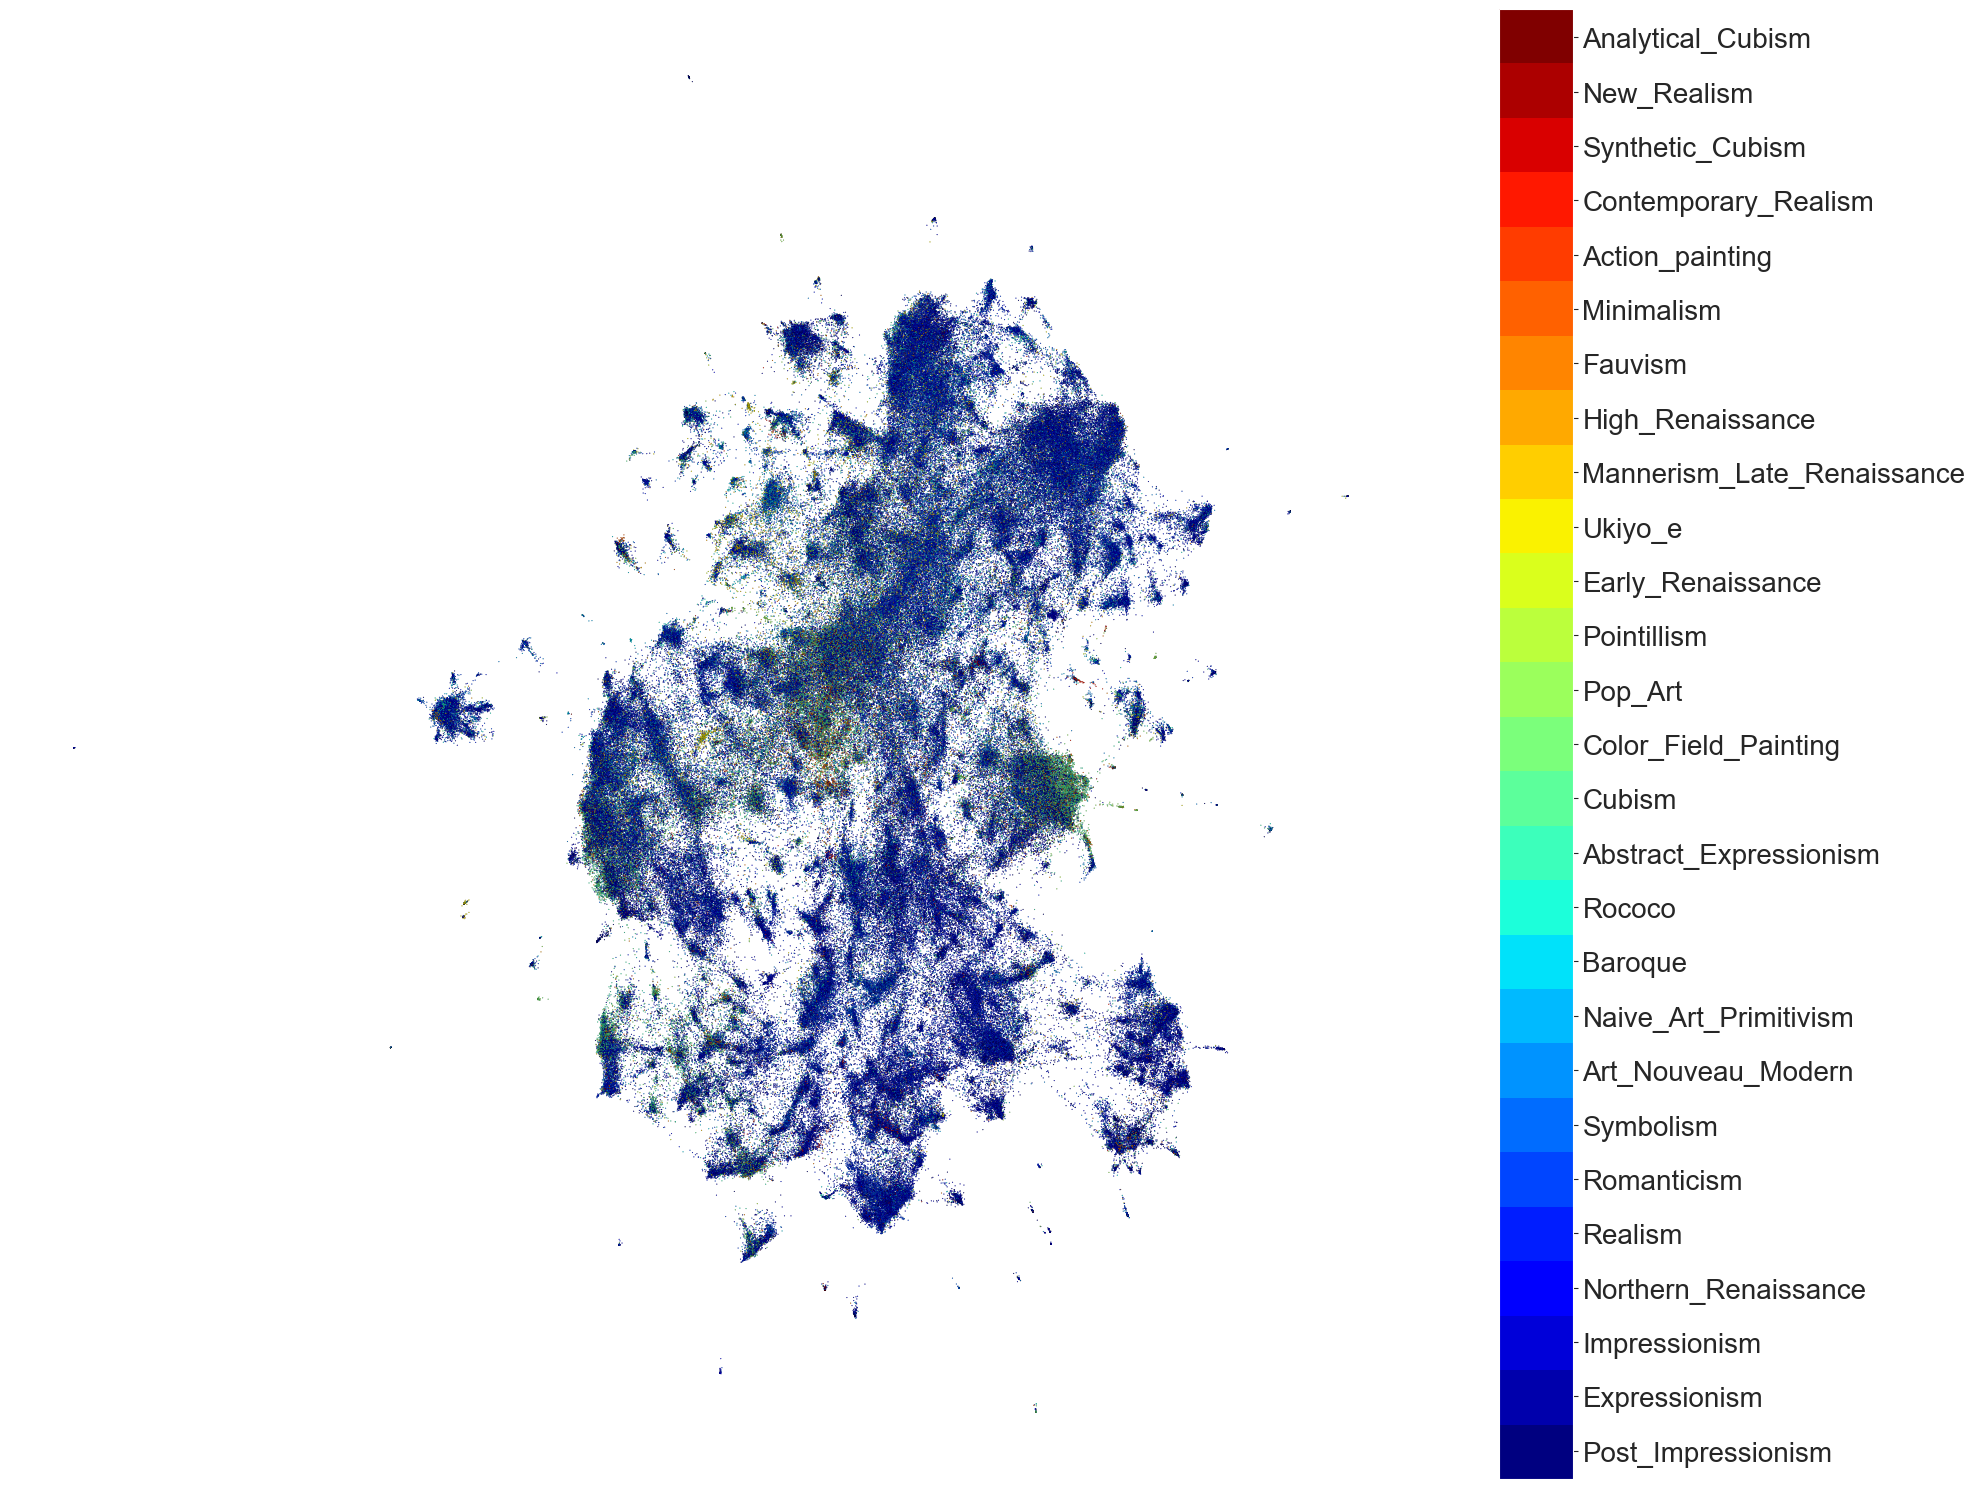

In [32]:
unique_labels = list(artemis['art_style'].unique())
true_labels = numpy.array([unique_labels.index(i) for i in artemis['art_style']])

cluster_scatter(X=text_x_2d,
                labels=true_labels,
                label_names=unique_labels,
                include_noise=False,
                point_size=0.5)

## B) Image

In [46]:
import pathlib

data_root = pathlib.Path("/mnt/HDD/DATA/ARTEMIS/artemis_official_data"
                         "/official_data/wikiart/")

def most_frequent(List):
    return max(set(List), key = List.count)

visual_artemis = {'path': [], 'emotion': []}
unique_paitings = artemis['painting'].unique()
for p, painting in tqdm(enumerate(unique_paitings), total=len(unique_paitings)):
    artemis_p = artemis[artemis['painting'] == painting]
    most_emotion = most_frequent(list(artemis_p['emotion'].values))
    visual_artemis['path'].append(
        data_root / artemis_p.iloc[0]['art_style'] / (artemis_p.iloc[0]['painting'] + '.jpg')
    )
    visual_artemis['emotion'].append(most_emotion)

visual_artemis = pandas.DataFrame(visual_artemis)
visual_artemis

100%|██████████| 80031/80031 [27:53<00:00, 47.83it/s]  


,path,emotion
0,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...,something else
1,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...,awe
2,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...,amusement
3,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...,amusement
4,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...,contentment
...,...,...
80026,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...,awe
80027,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...,awe
80028,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...,awe
80029,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...,disgust


In [ ]:
visual_x = compute_embeddings(modal='image',
                            data=visual_artemis['path'],
                            delete_after=False,
                            tmp="artemis-image-CLIP")
visual_x = numpy.array(visual_x)
visual_x.shape

 64%|██████▍   | 51325/80031 [3:58:45<2:36:55,  3.05it/s] 